<a href="https://colab.research.google.com/github/guyvdp1/thesis/blob/main/Thesis_Final_GuyvanderPlas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import** **packages**

In [ ]:
#importpackages
import datetime
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib import pyplot
from google.colab import drive
import seaborn as sns
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from tensorflow.keras.layers import GRU, SimpleRNN, Activation, LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
print(tf.test.gpu_device_name())
!nvidia-smi
!cat /proc/cpuinfo
# !cat /proc/meminfo

/device:GPU:0
Wed Jun 23 23:31:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    40W / 300W |    427MiB / 16160MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                          

# **Load data**

In [ ]:
#Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Open dataset from specific filepath
with open('/content/drive/MyDrive/Thesis/release_10_23_2020.csv', 'rb') as f:
  #store in pandas dataframe
    df = pd.read_csv(f)

# **First Look at data**

In [ ]:
#First look at the raw dataset
print(df.shape)
print(tabulate(df.head(), headers = 'keys', tablefmt = 'fancy_grid'))

(5433611, 6)
╒════╤══════════════════════════════════════════╤══════════════╤══════════════════╤══════════════════════════════════════════════════════════════════╤═════════════════════════════╤══════════════════════════════════════════════════════════════════╕
│    │ session_id_hash                          │ event_type   │ product_action   │ product_skus_hash                                                │   server_timestamp_epoch_ms │ hashed_url                                                       │
╞════╪══════════════════════════════════════════╪══════════════╪══════════════════╪══════════════════════════════════════════════════════════════════╪═════════════════════════════╪══════════════════════════════════════════════════════════════════╡
│  0 │ 00000005c19449b57d8d05dfc8b5474be0654032 │ pageview     │ nan              │ nan                                                              │               1544469996111 │ da99729886aff70a02733b6cd69ee7df35622d9302347ebdd9022a08b7125a

In [ ]:
#info regarding the dtypes of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5433611 entries, 0 to 5433610
Data columns (total 6 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   session_id_hash            object
 1   event_type                 object
 2   product_action             object
 3   product_skus_hash          object
 4   server_timestamp_epoch_ms  int64 
 5   hashed_url                 object
dtypes: int64(1), object(5)
memory usage: 248.7+ MB


In [ ]:
#basic info
df.describe(include=np.object)

,session_id_hash,event_type,product_action,product_skus_hash,hashed_url
count,5433611,5433611,2514822,1886054,5433611
unique,443660,2,5,38344,256598
top,fec99c62a5c3b540191c87b4e7e8a94a397f246d,pageview,detail,29178ed23f2eecc0cc51f51bace02c52f5a326a4bea8af...,b6133a35ba149e49bcfa0f6481add6f2b88b947731ca02...
freq,7579,4565253,1640190,10327,688361


In [ ]:
#shape of the dataframe
df.shape

(5433611, 6)

# **Label product events and drop columns**

In [ ]:
#drop columns not needed
coldrop = [1,3,4,5]
  # columns that are dropped:
    # event_type
    # product_skus_hash
    # server_timestamp_epoch_ms
    # hashed_url

df.drop(df.columns[coldrop], axis=1, inplace=True)


In [ ]:
print(tabulate(df.head(), headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤══════════════════════════════════════════╤══════════════════╕
│    │ session_id_hash                          │ product_action   │
╞════╪══════════════════════════════════════════╪══════════════════╡
│  0 │ 00000005c19449b57d8d05dfc8b5474be0654032 │ nan              │
├────┼──────────────────────────────────────────┼──────────────────┤
│  1 │ 00006a0ada94a5186163a25e9ed9c94481c820d9 │ nan              │
├────┼──────────────────────────────────────────┼──────────────────┤
│  2 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │ nan              │
├────┼──────────────────────────────────────────┼──────────────────┤
│  3 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │ nan              │
├────┼──────────────────────────────────────────┼──────────────────┤
│  4 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │ detail           │
╘════╧══════════════════════════════════════════╧══════════════════╛


In [ ]:
#convert nan to view
df = df.fillna(value='view')

#convert product_action column values to numbers:
# 1 = view
# 2 = detail
# 3 = click
# 4 = remove
# 5 = purchase
# 6 = add


df["product_action"].replace({"view": 1, "detail": 2,"add": 6, "remove": 4,"purchase": 5, "click": 3}, inplace=True)

In [ ]:
#check if it worked
print(tabulate(df.head(), headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤══════════════════════════════════════════╤══════════════════╕
│    │ session_id_hash                          │   product_action │
╞════╪══════════════════════════════════════════╪══════════════════╡
│  0 │ 00000005c19449b57d8d05dfc8b5474be0654032 │                1 │
├────┼──────────────────────────────────────────┼──────────────────┤
│  1 │ 00006a0ada94a5186163a25e9ed9c94481c820d9 │                1 │
├────┼──────────────────────────────────────────┼──────────────────┤
│  2 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │                1 │
├────┼──────────────────────────────────────────┼──────────────────┤
│  3 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │                1 │
├────┼──────────────────────────────────────────┼──────────────────┤
│  4 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │                2 │
╘════╧══════════════════════════════════════════╧══════════════════╛


# **EDA**

<function matplotlib.pyplot.show>

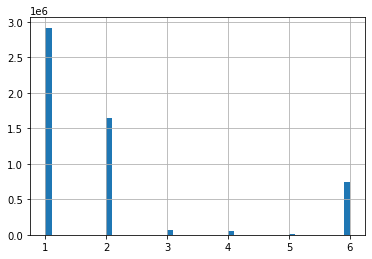

In [ ]:
#show the distribution off the different events
df["product_action"].hist(bins=50)
plt.show



In [ ]:
# statistics of the dataset
print("Total unique events: ", df['session_id_hash'].count())
print("Total unique sessions: ", df['session_id_hash'].nunique())
print("Total unique product actions: ", df['product_action'].nunique())

Total unique events:  5433611
Total unique sessions:  443660
Total unique product actions:  6


In [ ]:
# counting the different events in the product_action column
df["product_action"].value_counts()

1    2918789
2    1640190
6     743363
3      69831
4      51512
5       9926
Name: product_action, dtype: int64

# **Add target column, trim sequences to event before add to cart if available and trim the total lenght of the sequences**

In [ ]:
df2 = df

In [ ]:
# create new sequence grouped by session_id_hash and sequence of product_action
sequence = df2.groupby('session_id_hash')['product_action'].apply(list)
sequence = sequence.reset_index()
#add add_to_cart target value
sequence['add_to_cart'] = sequence['product_action'].apply(lambda x: 1 if 6 in x else 0)
#remove sequences with lenght 1
sequence = sequence[sequence['product_action'].map(len)> 1]

#show result
print('Total number of records=', sequence.shape[0])
print(tabulate(sequence.head(), headers = 'keys', tablefmt = 'fancy_grid'))

Total number of records= 305004
╒════╤══════════════════════════════════════════╤══════════════════════════════════════════════════╤═══════════════╕
│    │ session_id_hash                          │ product_action                                   │   add_to_cart │
╞════╪══════════════════════════════════════════╪══════════════════════════════════════════════════╪═══════════════╡
│  2 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │ [1, 1, 2, 1, 2, 1, 2]                            │             0 │
├────┼──────────────────────────────────────────┼──────────────────────────────────────────────────┼───────────────┤
│  3 │ 0000c49d1359c87f112285d63a9fc0d4c50f73b4 │ [1, 1, 1]                                        │             0 │
├────┼──────────────────────────────────────────┼──────────────────────────────────────────────────┼───────────────┤
│  5 │ 00014c4428e61aca7e64be1064d2b6cf49233cfb │ [1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1] │             0 │
├────┼──────────────────────────

In [ ]:
#remove 6 from sequences
sequence['product_action']= sequence.product_action.apply(lambda row: list(filter(lambda a: a != 6, row)))

#show result
print('Total number of records=', sequence.shape[0])
print(tabulate(sequence.head(5), headers = 'keys', tablefmt = 'fancy_grid'))

Total number of records= 305004
╒════╤══════════════════════════════════════════╤══════════════════════════════════════════════════╤═══════════════╕
│    │ session_id_hash                          │ product_action                                   │   add_to_cart │
╞════╪══════════════════════════════════════════╪══════════════════════════════════════════════════╪═══════════════╡
│  2 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │ [1, 1, 2, 1, 2, 1, 2]                            │             0 │
├────┼──────────────────────────────────────────┼──────────────────────────────────────────────────┼───────────────┤
│  3 │ 0000c49d1359c87f112285d63a9fc0d4c50f73b4 │ [1, 1, 1]                                        │             0 │
├────┼──────────────────────────────────────────┼──────────────────────────────────────────────────┼───────────────┤
│  5 │ 00014c4428e61aca7e64be1064d2b6cf49233cfb │ [1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1] │             0 │
├────┼──────────────────────────

In [ ]:
# add lenght of sequences column
sequence['lenght'] = sequence['product_action'].map(len).to_list()

#show result
print(tabulate(sequence.head(), headers = 'keys', tablefmt = 'fancy_grid'))
sequence.shape

╒════╤══════════════════════════════════════════╤══════════════════════════════════════════════════╤═══════════════╤══════════╕
│    │ session_id_hash                          │ product_action                                   │   add_to_cart │   lenght │
╞════╪══════════════════════════════════════════╪══════════════════════════════════════════════════╪═══════════════╪══════════╡
│  2 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │ [1, 1, 2, 1, 2, 1, 2]                            │             0 │        7 │
├────┼──────────────────────────────────────────┼──────────────────────────────────────────────────┼───────────────┼──────────┤
│  3 │ 0000c49d1359c87f112285d63a9fc0d4c50f73b4 │ [1, 1, 1]                                        │             0 │        3 │
├────┼──────────────────────────────────────────┼──────────────────────────────────────────────────┼───────────────┼──────────┤
│  5 │ 00014c4428e61aca7e64be1064d2b6cf49233cfb │ [1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1] │    

(305004, 4)

In [ ]:
# store lenght in variable
length = sequence['product_action'].map(len).to_list()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


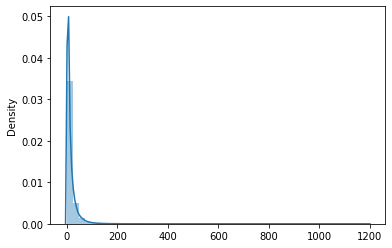

In [ ]:
#plot the lenght of the sequences before trimming to lenght >= 5 and lenght =< 155
sns.distplot(length)

In [ ]:
#trim. sequences to lenght > 5 and lenght < 155
sequence = sequence.drop(sequence[sequence.lenght < 5].index)
sequence = sequence.drop(sequence[sequence.lenght > 155].index)
sequence.shape

(203895, 4)

In [ ]:
#drop sequence lenght column
sequence.drop(sequence.columns[3], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


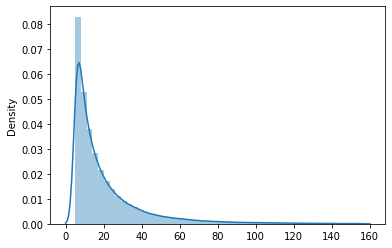

In [ ]:
#plot the lenght of the sequences after trimming to lenght > 5 and lenght < 155
length = sequence['product_action'].map(len).to_list()
sns.distplot(length)

# **Create Train Test split for all models + balancing the train data**

In [ ]:
X = sequence['product_action']
y = sequence['add_to_cart']

In [ ]:
#padding the sequences 
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding="post",value=0)
print('padded X shape=', X.shape)


padded X shape= (203895, 155)


In [ ]:
# define y and calculate the percentage of add to cart sessions
from collections import Counter

y = sequence['add_to_cart']

z=np.sum(y)/len(y)

print('Percentage of add to cart sessions=',z*100,"%")

Percentage of add to cart sessions= 18.481080948527428 %


In [ ]:
# define function for Train Test split
def prepare_train_test_data(data,y):
  #train test split 70/30
  X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=101)

  #reshaping X_train and X_test
  # X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],6))
  # X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],6))
  return (X_train,X_test,y_train,y_test)

In [ ]:
#create train and testing data
X_train, X_test, y_train, y_test=prepare_train_test_data(X,y)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape )
print(X_val.shape,y_val.shape)


(142726, 155) (142726,) (30584, 155) (30584,)
(30585, 155) (30585,)


In [ ]:
# define oversampler
from imblearn.over_sampling import RandomOverSampler 
oversampler = RandomOverSampler(sampling_strategy=1, random_state=101)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#oversample the data


X = X_train.reshape(len(X_train),-1)


y = y_train



X_oversampled, y_oversampled = oversampler.fit_resample(X, y)
print(Counter(y_oversampled))
print(y_oversampled.shape)
print(X_oversampled.shape)

#shuffle so that de add to cart sessions occur random
from sklearn.utils import shuffle
X_oversampled,y_oversampled = shuffle(X_oversampled, y_oversampled, random_state=0)
z=np.sum(y_oversampled)/len(y_oversampled)
print('Percentage of add to cart sessions=',z*100,"%")


Counter({0: 116310, 1: 116310})
(232620,)
(232620, 155)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Percentage of add to cart sessions= 50.0 %


# **One hot encoding for LSTM, GRU and Conv1D models**

In [ ]:
#for one hot encoding
X_trainhot = X_oversampled
X_valhot = X_val
X_testhot = X_test
y_trainhot = y_oversampled
y_valhot = y_val
y_testhot = y_test

In [ ]:
# hot encoding
X_trainhot = to_categorical(X_trainhot, num_classes=6)
print(X_trainhot.shape)
print('y_trainhot shape=', y_trainhot.shape)
X_valhot = to_categorical(X_valhot, num_classes=6)
print(X_valhot.shape)
print('y_valhot shape=', y_valhot.shape)
X_testhot = to_categorical(X_testhot, num_classes=6)
print(X_testhot.shape)
print('y_testhot shape=', y_testhot.shape)

(232620, 155, 6)
y_trainhot shape= (232620,)
(30585, 155, 6)
y_valhot shape= (30585,)
(30584, 155, 6)
y_testhot shape= (30584,)


In [ ]:
#variables to make the ngrams
X_traingram = X_oversampled
X_valgram = X_val
X_testgram = X_test
y_traingram = y_oversampled
y_valgram = y_val
y_testgram = y_test


X_print = X_oversampled

In [ ]:
print(len(X_traingram[1]))

155


In [ ]:
X_traingram2 = []
for lis in X_traingram:

  x = map(str, lis) 
  X_traingram2.append(x)

X_valgram2 = []
for lis in X_valgram:
  x = map(str, lis) 
  X_valgram2.append(x)
  
X_testgram2 = []
for lis in X_testgram:
  x = map(str, lis) 
  X_testgram2.append(x)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
#variable to make the ngram --> n=2 is bigram n=3 is trigram etc
n=2
vectorizer = CountVectorizer( lowercase=False, tokenizer = lambda x:x ,ngram_range = (n,n), stop_words= frozenset(['0']), vocabulary=[' <s> 1', ' <s> 2', ' <s> 3', ' <s> 4', '1 1', '1 2', '1 3', '1 4', '1 5', '1 </s>', '2 1', '2 2', '2 3', '2 4', '2 5', '2 </s>', '3 1', '3 2', '3 3', '3 4', '3 </s>', '4 1', '4 2', '4 4', '4 5', '4 </s>', '5 1', '5 2', '5 5', '5 </s>'])
X_traingram = pd.DataFrame(X_traingram2)
X_traingram = X_traingram.to_numpy()


X_traingram1 = []

for item in X_traingram:
  for x in range(n-1):
    item = np.insert(item,0," <s>")
    item = np.append(item, '</s>')
  
  X_traingram1.append(item)


X_valgram = pd.DataFrame(X_valgram2)
X_valgram = X_valgram.to_numpy()

X_valgram1 = []

for item in X_valgram:
  for x in range(n-1):
    item = np.insert(item,0," <s>")
    item = np.append(item, '</s>')
  
  X_valgram1.append(item)

X_testgram = pd.DataFrame(X_testgram2)
X_testgram = X_testgram.to_numpy()

X_testgram1 = []

for item in X_testgram:
  for x in range(n-1):
    item = np.insert(item,0," <s>")
    item = np.append(item, '</s>')
  
  X_testgram1.append(item)


X_traingram = vectorizer.fit_transform( X_traingram1 )
X_valgram = vectorizer.fit_transform( X_valgram1 )
X_testgram = vectorizer.fit_transform( X_testgram1 )

X_traingram = X_traingram.toarray()
X_valgram = X_valgram.toarray()
X_testgram = X_testgram.toarray()

In [ ]:
X_print = X_oversampled

In [ ]:
X_traingram = list(X_traingram)

print(X_print[1])
print(X_traingram[1])
print(X_valgram[1])
print(X_testgram[1])
print(len(X_traingram[1]))
print(len(X_valgram[1]))
print(len(X_testgram[1]))

print(vectorizer.get_feature_names()) 

[1 1 1 2 1 2 1 1 2 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[1 0 0 0 7 3 0 0 0 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 6 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1  0  0  0  1 14  0  0  0  1 14  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
30
30
30
[' <s> 1', ' <s> 2', ' <s> 3', ' <s> 4', '1 1', '1 2', '1 3', '1 4', '1 5', '1 </s>', '2 1', '2 2', '2 3', '2 4', '2 5', '2 </s>', '3 1', '3 2', '3 3', '3 4', '3 </s>', '4 1', '4 2', '4 4', '4 5', '4 </s>', '5 1', '5 2', '5 5', '5 </s>']


# **plot functions and eva methods**

In [ ]:
from matplotlib import pyplot
def plot_history(history):
  # plot model fitting process
  print(history.history.keys())
  

  # plot train and validation loss
  pyplot.plot(history.history['loss'])
  pyplot.plot(history.history['val_loss'])
  pyplot.title('model train vs validation loss')
  pyplot.ylabel('loss')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'validation'], loc='upper right')
  pyplot.show()

  # summarize accuracy history
  pyplot.plot(history.history['acc'])
  pyplot.plot(history.history['val_acc'])
  pyplot.title('model train acc vs validation acc')
  pyplot.ylabel('acc')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'validation'], loc='lower right')
  pyplot.show()



def evaluate_on_test(X_test, y_test, training_model):
  #eveluate on test data
  g_preds=training_model.predict_classes(X_test)
  gaccuracy = accuracy_score(y_test, g_preds)
  print('Accuracy: %f' % gaccuracy)
  # precision tp / (tp + fp)
  gprecision = precision_score(y_test, g_preds)
  print('Precision: %f' % gprecision)
  # recall: tp / (tp + fn)
  grecall = recall_score(y_test, g_preds)
  print('Recall: %f' % grecall)
  # f1: 2 tp / (2 tp + fp + fn)
  gf1 = f1_score(y_test, g_preds)
  print('F1 score: %f' % gf1)
  # ROC and AUC
  auc_roc_0 = str(roc_auc_score(y_test, g_preds))
  print('AUC: \n' + auc_roc_0)
  
  print(classification_report(y_test, g_preds))

  cm = metrics.confusion_matrix(y_test, g_preds, normalize='true')

  #confusion matrix
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'coolwarm');
  sns.set(font_scale=1.2)
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Auc: {0}'.format(auc_roc_0)
  plt.title(all_sample_title, size = 15);

  #roc curve
  fpr, tpr, thresholds = roc_curve(y_test, training_model.predict_classes(X_test))
  plt.figure()
  plt.plot(fpr, tpr, label='(area = %0.2f)' % roc_auc_score(y_test, g_preds))
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  

  
  

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

# **dummy classifier**

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     24944
           1       0.00      0.00      0.00      5640

    accuracy                           0.82     30584
   macro avg       0.41      0.50      0.45     30584
weighted avg       0.67      0.82      0.73     30584



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


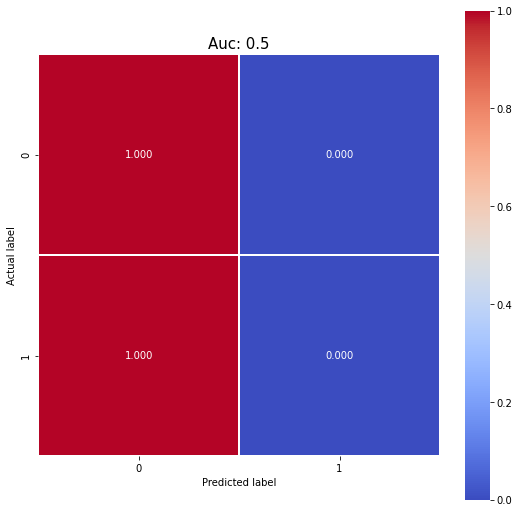

In [ ]:
#majority baseline
from sklearn.dummy import DummyClassifier
X = X_oversampled
y = y_oversampled
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)

score1 = dummy_clf.predict(X_test)

dummy_clf.score(X_test, y_test)


cm = metrics.confusion_matrix(y_testgram, score1,normalize='true')
print(classification_report(y_testgram, score1))

auc_roc_0 = str(roc_auc_score(y_testgram, score1))
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'coolwarm');
sns.set(font_scale=1.2)
plt.tick_params(labelsize=10)
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Auc: {0}'.format(auc_roc_0)
plt.title(all_sample_title, size = 15);

              precision    recall  f1-score   support

           0       0.81      0.50      0.62     24944
           1       0.18      0.49      0.27      5640

    accuracy                           0.50     30584
   macro avg       0.50      0.50      0.44     30584
weighted avg       0.70      0.50      0.55     30584



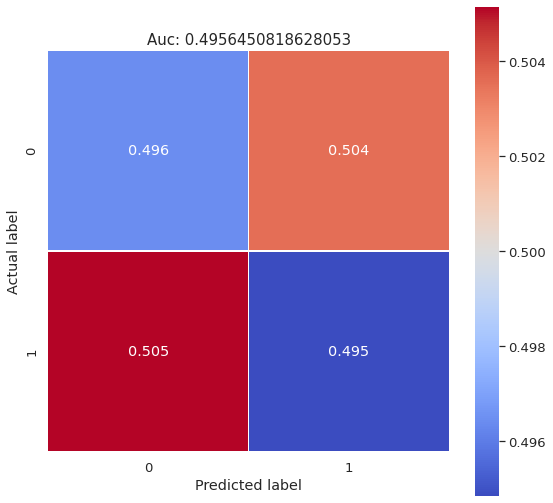

In [ ]:
#random baseline
from sklearn.dummy import DummyClassifier
X = X_oversampled
y = y_oversampled
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X, y)

score1 = dummy_clf.predict(X_test)

dummy_clf.score(X_test, y_test)


cm = metrics.confusion_matrix(y_testgram, score1,normalize='true')
print(classification_report(y_testgram, score1))

auc_roc_0 = str(roc_auc_score(y_testgram, score1))
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'coolwarm');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Auc: {0}'.format(auc_roc_0)
plt.title(all_sample_title, size = 15);

# **LSTM**

In [ ]:
#Build the model sequence to label
def LSTM_model(neurons):
  model= tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(neurons,return_sequences=False,input_shape = (155,6)))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

  model.compile(optimizer=(tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam') ), loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'acc'])

  return model


In [ ]:
#show model
tf.keras.backend.clear_session()
training_model = LSTM_model(100)
training_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               42800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model
with tf.device('/gpu:0'):
  lstm_history = training_model.fit(X_trainhot ,y_trainhot,
  epochs=20,
  batch_size=16,
  callbacks=[early_stopping],
  validation_data = (X_valhot,y_valhot))

Epoch 1/20
14539/14539 [==============================] - 125s 8ms/step - loss: 0.6248 - recall: 0.5761 - precision: 0.6034 - acc: 0.5987 - val_loss: 0.4871 - val_recall: 0.7094 - val_precision: 0.4151 - val_acc: 0.7627
Epoch 2/20
14539/14539 [==============================] - 124s 9ms/step - loss: 0.4991 - recall: 0.6957 - precision: 0.7546 - acc: 0.7348 - val_loss: 0.4609 - val_recall: 0.7264 - val_precision: 0.4009 - val_acc: 0.7500
Epoch 3/20
14539/14539 [==============================] - 126s 9ms/step - loss: 0.4950 - recall: 0.6980 - precision: 0.7611 - acc: 0.7395 - val_loss: 0.4675 - val_recall: 0.6870 - val_precision: 0.4321 - val_acc: 0.7764
Epoch 4/20
14539/14539 [==============================] - 125s 9ms/step - loss: 0.4924 - recall: 0.6971 - precision: 0.7640 - acc: 0.7409 - val_loss: 0.4995 - val_recall: 0.7417 - val_precision: 0.3911 - val_acc: 0.7401
Epoch 5/20
14539/14539 [==============================] - 123s 8ms/step - loss: 0.4903 - recall: 0.7014 - precision: 0.7

dict_keys(['loss', 'recall', 'precision', 'acc', 'val_loss', 'val_recall', 'val_precision', 'val_acc'])


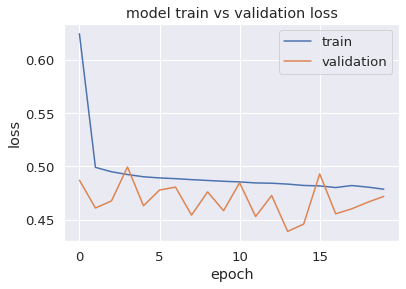

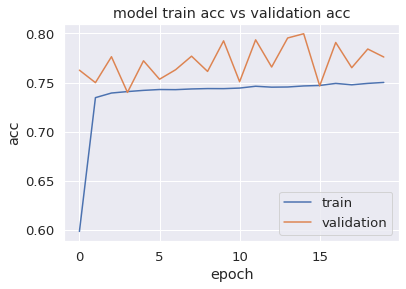

In [ ]:
#Use plot_history function to plot the model curves for loss and accuracy
plot_history(lstm_history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.771220
Precision: 0.424198
Recall: 0.673227
F1 score: 0.520458
AUC: 
0.733302057601936
              precision    recall  f1-score   support

           0       0.91      0.79      0.85     24944
           1       0.42      0.67      0.52      5640

    accuracy                           0.77     30584
   macro avg       0.67      0.73      0.69     30584
weighted avg       0.82      0.77      0.79     30584



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


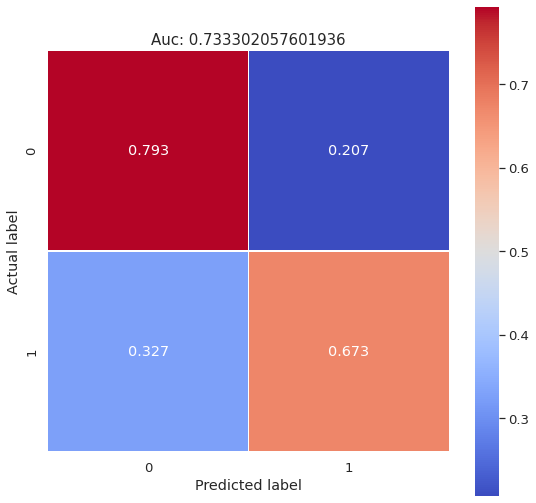

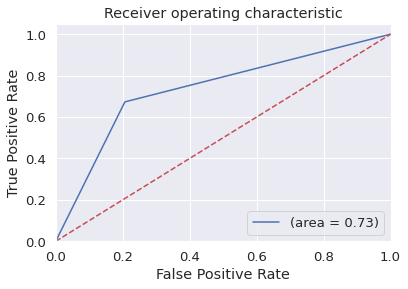

In [ ]:
# Use evaluate_on_test function to note accuracy, precision, recall and F1 score on test data
evaluate_on_test(X_testhot, y_testhot, training_model)

# **GRU**

In [ ]:
#define GRU
def GRU_model(neurons):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.GRU(neurons, return_sequences = False, input_shape = (155,6)))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=(tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam') ), loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'acc'])
    return model

In [ ]:
#Visualize the Model 
tf.keras.backend.clear_session()
G_model = GRU_model(100)
G_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100)               32400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 32,501
Trainable params: 32,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train the G_model
with tf.device('/gpu:0'): 
  g_history = G_model.fit(X_trainhot, y_trainhot,
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stopping],
                    validation_data = (X_valhot,y_valhot))

Epoch 1/20
3635/3635 [==============================] - 40s 11ms/step - loss: 0.5139 - recall: 0.6619 - precision: 0.7521 - acc: 0.7219 - val_loss: 0.5605 - val_recall: 0.5076 - val_precision: 0.4578 - val_acc: 0.7988
Epoch 2/20
3635/3635 [==============================] - 37s 10ms/step - loss: 0.5133 - recall: 0.6702 - precision: 0.7537 - acc: 0.7256 - val_loss: 0.4499 - val_recall: 0.6561 - val_precision: 0.4622 - val_acc: 0.7963
Epoch 3/20
3635/3635 [==============================] - 38s 10ms/step - loss: 0.5013 - recall: 0.6775 - precision: 0.7619 - acc: 0.7329 - val_loss: 0.4816 - val_recall: 0.6646 - val_precision: 0.4520 - val_acc: 0.7901
Epoch 4/20
3635/3635 [==============================] - 37s 10ms/step - loss: 0.5025 - recall: 0.6755 - precision: 0.7645 - acc: 0.7337 - val_loss: 0.5211 - val_recall: 0.7693 - val_precision: 0.3714 - val_acc: 0.7181
Epoch 5/20
3635/3635 [==============================] - 37s 10ms/step - loss: 0.4981 - recall: 0.6757 - precision: 0.7684 - acc:

dict_keys(['loss', 'recall', 'precision', 'acc', 'val_loss', 'val_recall', 'val_precision', 'val_acc'])


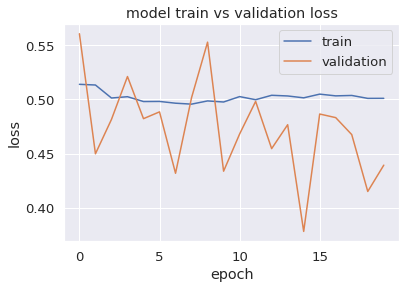

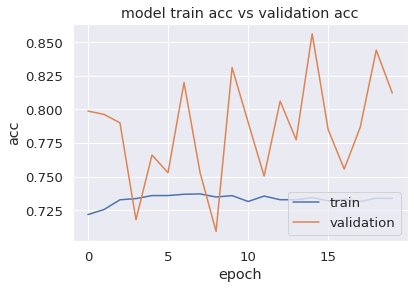

In [ ]:
#plot the model curves for loss and accuracy
plot_history(g_history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.808462
Precision: 0.484966
Recall: 0.623404
F1 score: 0.545539
AUC: 
0.7368544689039619
              precision    recall  f1-score   support

           0       0.91      0.85      0.88     24944
           1       0.48      0.62      0.55      5640

    accuracy                           0.81     30584
   macro avg       0.70      0.74      0.71     30584
weighted avg       0.83      0.81      0.82     30584



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


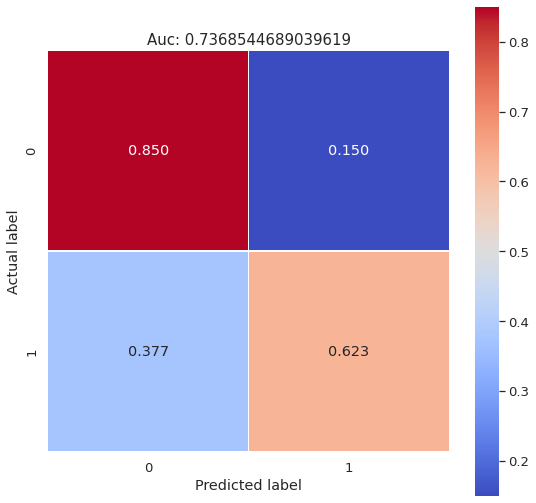

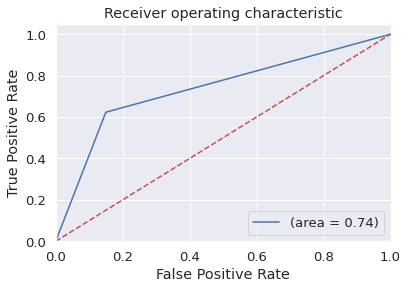

In [ ]:
# Use evaluate_on_test 
evaluate_on_test(X_testhot, y_testhot, G_model)

# **Conv1D + LSTM**

In [ ]:
#define GRU
def CLSTM_model(neurons):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1, padding='valid', activation='relu', input_shape=(155,6)))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.LSTM(neurons, return_sequences = False))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=(tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam') ), loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'acc'])
    return model

In [ ]:
tf.keras.backend.clear_session()
CLSTMmodel = CLSTM_model(100)
CLSTMmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 155, 16)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 77, 16)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               46800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 47,013
Trainable params: 47,013
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model
with tf.device('/gpu:0'): 
              clstm_history =       CLSTMmodel.fit(X_trainhot, y_trainhot,
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stopping],
                    validation_data = (X_valhot,y_valhot))

Epoch 1/20
3635/3635 [==============================] - 27s 7ms/step - loss: 0.5266 - recall: 0.6639 - precision: 0.7363 - acc: 0.7131 - val_loss: 0.4786 - val_recall: 0.6557 - val_precision: 0.4564 - val_acc: 0.7930
Epoch 2/20
3635/3635 [==============================] - 24s 7ms/step - loss: 0.4995 - recall: 0.6852 - precision: 0.7648 - acc: 0.7373 - val_loss: 0.4794 - val_recall: 0.7142 - val_precision: 0.4129 - val_acc: 0.7606
Epoch 3/20
3635/3635 [==============================] - 24s 7ms/step - loss: 0.4956 - recall: 0.6886 - precision: 0.7666 - acc: 0.7395 - val_loss: 0.4206 - val_recall: 0.6049 - val_precision: 0.5084 - val_acc: 0.8197
Epoch 4/20
3635/3635 [==============================] - 24s 7ms/step - loss: 0.4936 - recall: 0.6860 - precision: 0.7690 - acc: 0.7400 - val_loss: 0.5049 - val_recall: 0.7476 - val_precision: 0.3904 - val_acc: 0.7388
Epoch 5/20
3635/3635 [==============================] - 24s 7ms/step - loss: 0.4921 - recall: 0.6915 - precision: 0.7679 - acc: 0.74

dict_keys(['loss', 'recall', 'precision', 'acc', 'val_loss', 'val_recall', 'val_precision', 'val_acc'])


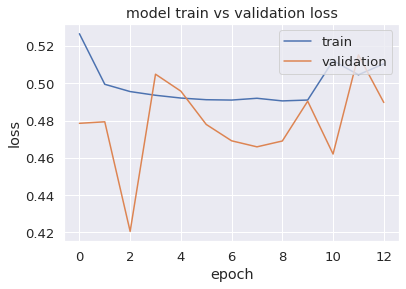

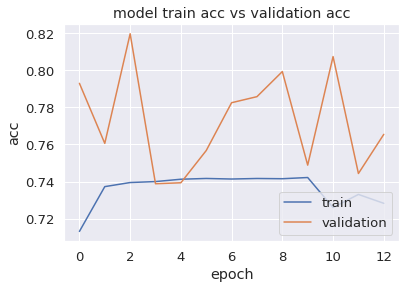

In [ ]:
#plot the model curves for loss and accuracy
plot_history(clstm_history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.818631
Precision: 0.506861
Recall: 0.609043
F1 score: 0.553274
AUC: 
0.737531218866431
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     24944
           1       0.51      0.61      0.55      5640

    accuracy                           0.82     30584
   macro avg       0.71      0.74      0.72     30584
weighted avg       0.83      0.82      0.82     30584



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


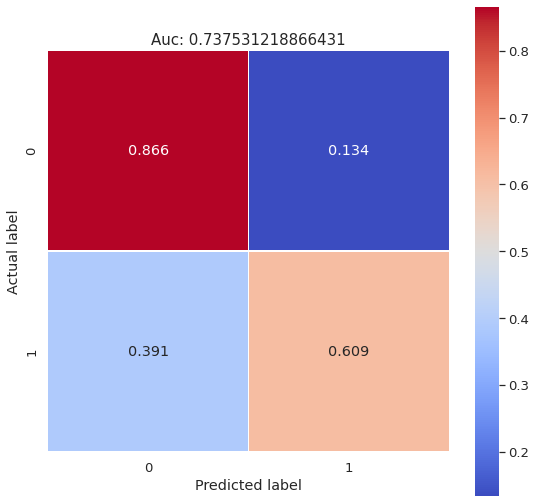

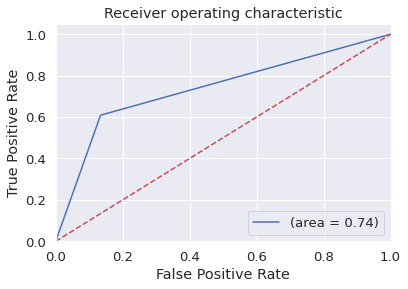

In [ ]:
# Use evaluate_on_test 
evaluate_on_test(X_testhot, y_testhot, CLSTMmodel)

# **Conv1D + GRU**

In [ ]:

def CGRU_model(neurons):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='valid', activation='relu', input_shape=(155,6)))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.GRU(neurons, return_sequences = False))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=(tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam') ), loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'acc'])
    return model

In [ ]:
tf.keras.backend.clear_session()
CG_model = CGRU_model(100)
CG_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 153, 32)           608       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 76, 32)            0         
_________________________________________________________________
gru (GRU)                    (None, 100)               40200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,909
Trainable params: 40,909
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train 
with tf.device('/gpu:0'): 
  cg_history = CG_model.fit(X_trainhot, y_trainhot,
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stopping],
                    validation_data = (X_valhot,y_valhot))

Epoch 1/20
3635/3635 [==============================] - 32s 8ms/step - loss: 0.5213 - recall: 0.6531 - precision: 0.7420 - acc: 0.7130 - val_loss: 0.5001 - val_recall: 0.7362 - val_precision: 0.3946 - val_acc: 0.7437
Epoch 2/20
3635/3635 [==============================] - 29s 8ms/step - loss: 0.4933 - recall: 0.6858 - precision: 0.7686 - acc: 0.7396 - val_loss: 0.4529 - val_recall: 0.6319 - val_precision: 0.4853 - val_acc: 0.8090
Epoch 3/20
3635/3635 [==============================] - 29s 8ms/step - loss: 0.4911 - recall: 0.6878 - precision: 0.7709 - acc: 0.7417 - val_loss: 0.4594 - val_recall: 0.6660 - val_precision: 0.4489 - val_acc: 0.7882
Epoch 4/20
3635/3635 [==============================] - 29s 8ms/step - loss: 0.4898 - recall: 0.6896 - precision: 0.7712 - acc: 0.7425 - val_loss: 0.4592 - val_recall: 0.6831 - val_precision: 0.4454 - val_acc: 0.7853
Epoch 5/20
3635/3635 [==============================] - 29s 8ms/step - loss: 0.4889 - recall: 0.6894 - precision: 0.7719 - acc: 0.74

dict_keys(['loss', 'recall', 'precision', 'acc', 'val_loss', 'val_recall', 'val_precision', 'val_acc'])


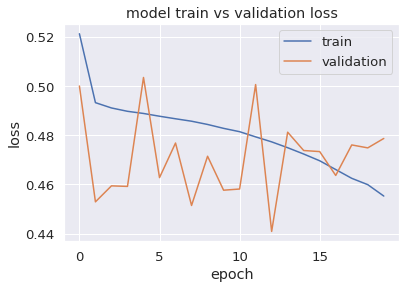

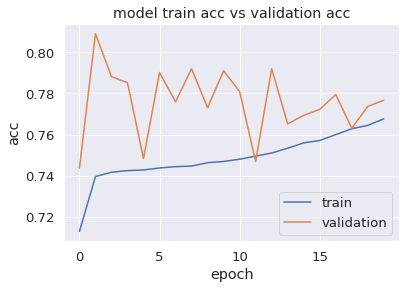

In [ ]:
#plot the model curves for loss and accuracy
plot_history(cg_history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.772038
Precision: 0.423641
Recall: 0.655142
F1 score: 0.514552
AUC: 
0.7268052067837631
              precision    recall  f1-score   support

           0       0.91      0.80      0.85     24944
           1       0.42      0.66      0.51      5640

    accuracy                           0.77     30584
   macro avg       0.67      0.73      0.68     30584
weighted avg       0.82      0.77      0.79     30584



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


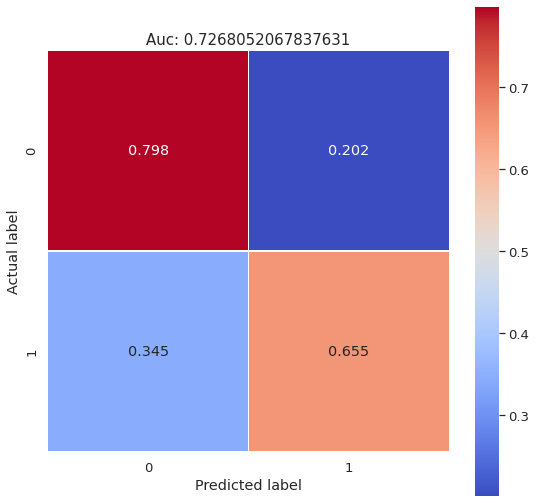

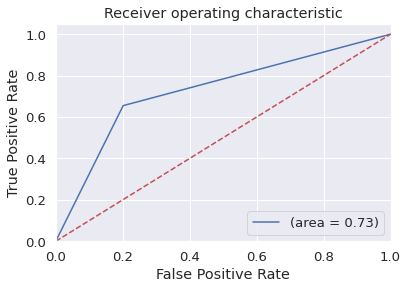

In [ ]:
# Use evaluate_on_test 
evaluate_on_test(X_testhot, y_testhot, CG_model)

# **Random forests**

In [ ]:
criterion = np.array(['gini', 'entropy'])
estimators = np.array([100,1000,2000,3000])
scores_rfc1 = {}

for k in criterion:
    for c in estimators:

        #fit
        rfc1=RandomForestClassifier(random_state=101, n_jobs= -1, n_estimators= c,criterion = k ,verbose=1)
        
        rfc1.fit(X_traingram, y_traingram)

        #validating scores on validation set
        acc = rfc1.score(X_valgram, y_valgram)
        
        scores_rfc1[k,c] = acc

print(scores_rfc1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 t

{('gini', 100): 0.7981690371096943, ('gini', 1000): 0.798757560895864, ('gini', 2000): 0.7989537354912539, ('gini', 3000): 0.7982998201732876, ('entropy', 100): 0.7982671244073892, ('entropy', 1000): 0.7985286905345758, ('entropy', 2000): 0.7988229524276607, ('entropy', 3000): 0.7983325159391859}


[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed:    6.7s finished


In [ ]:
# getting best k and p   
import operator
best_score = max(scores_rfc1.items(), key=operator.itemgetter(1))[0]
best_k = best_score[0]
best_c = best_score[1]
print(best_k)
print(best_c)



gini
2000


In [ ]:
rfc1=RandomForestClassifier(random_state=101, n_jobs= -1, n_estimators= best_c ,criterion = best_k ,verbose=1)
rfc1.fit(X_traingram, y_traingram)
probab_pred = rfc1.predict_proba(X_testgram)
predictions = rfc1.predict(X_testgram)
score = rfc1.score(X_testgram, y_testgram)

print(score)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Do

0.7943696050222339


[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    4.5s finished


In [ ]:
cm = metrics.confusion_matrix(y_testgram, predictions)
print(classification_report(y_testgram, predictions))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     24944
           1       0.45      0.55      0.50      5640

    accuracy                           0.79     30584
   macro avg       0.67      0.70      0.68     30584
weighted avg       0.81      0.79      0.80     30584



AUC: 
0.7000174006796501


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 2000 

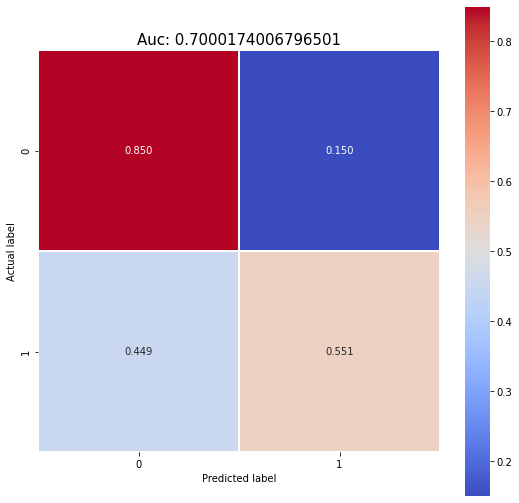

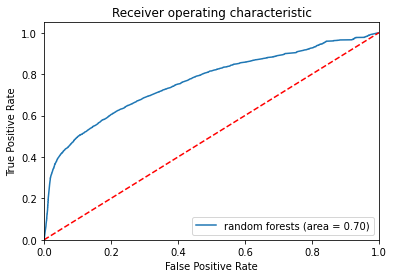

In [ ]:
auc_roc_0 = str(roc_auc_score(y_testgram, predictions))
print('AUC: \n' + auc_roc_0)


cm = metrics.confusion_matrix(y_testgram, predictions,normalize='true')
cm1 = metrics.confusion_matrix(y_testgram, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'coolwarm');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Auc: {0}'.format(auc_roc_0)
plt.title(all_sample_title, size = 15);



logit_roc_auc = roc_auc_score(y_testgram, rfc1.predict(X_testgram))
fpr, tpr, thresholds = roc_curve(y_testgram, rfc1.predict_proba(X_testgram)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='random forests (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


# **logistic regression**

In [ ]:
solver = np.array(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
C= np.array([0.1,1,10,100])
scores_logis = {}

for k in solver:
    for c in C:

        #fit
        logisticRegr = LogisticRegression(max_iter = 1000 , solver=k, verbose =1, n_jobs=-1, C = c )
        
        logisticRegr.fit(X_traingram, y_traingram)

        #validating scores on validation set
        acc = logisticRegr.score(X_valgram, y_valgram)
        
        scores_logis[k,c] = acc

print(scores_logis)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   21.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   31.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   37.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   47.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 511 epochs took 55 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   55.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 936 epochs took 102 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 114 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 107 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 734 epochs took 94 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 126 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 123 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 123 seconds
{('newton-cg', 0.1): 0.822854340362923, ('newton-cg', 1.0): 0.8228870361288213, ('newton-cg', 10.0): 0.8228870361288213, ('newton-cg', 100.0): 0.8229851234265163, ('lbfgs', 0.1): 0.8230832107242112, ('lbfgs', 1.0): 0.8229851234265163, ('lbfgs', 10.0): 0.8230178191924146, ('lbfgs', 100.0): 0.8228870361288213, ('liblinear', 0.1): 0.8229524276606179, ('liblinear', 1.0): 0.8229197318947197, ('liblinear', 10.0): 0.8229197318947197, ('liblinear', 100.0): 0.8229524276606179, ('sag', 0.1): 0.822854340362923, ('sag', 1.0): 0.8229197318947197, ('sag', 10.0): 0.8229197318947197, ('sag', 100.0): 0.8229197318947197, ('saga', 0.1): 0.8229197318947197, ('saga', 1.0): 0.8228870361288213, ('saga', 10.0): 0.8228870361288213, ('saga', 100.0): 0.8228870361288213}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.1min finished


In [ ]:
# getting best k and p   
import operator
best_score = max(scores_logis.items(), key=operator.itemgetter(1))[0]
best_k = best_score[0]
best_c = best_score[1]
print(best_k)
print(best_c)



lbfgs
0.1


In [ ]:
logisticRegr = LogisticRegression(max_iter = 1000 , solver=best_k, verbose =1, n_jobs=-1, C = best_c )
logisticRegr.fit(X_traingram, y_traingram)

predictions = logisticRegr.predict(X_testgram)
score = logisticRegr.score(X_testgram, y_testgram)

print(score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.8203308919696574


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   51.1s finished


In [ ]:
cm = metrics.confusion_matrix(y_testgram, predictions,normalize='true')
print(classification_report(y_testgram, predictions))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89     24944
           1       0.51      0.59      0.55      5640

    accuracy                           0.82     30584
   macro avg       0.71      0.73      0.72     30584
weighted avg       0.83      0.82      0.83     30584



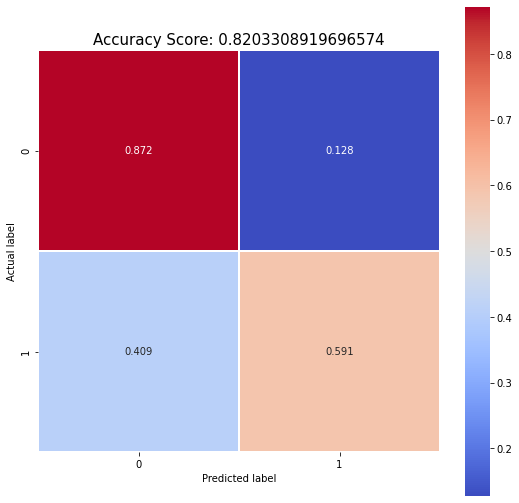

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'coolwarm');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

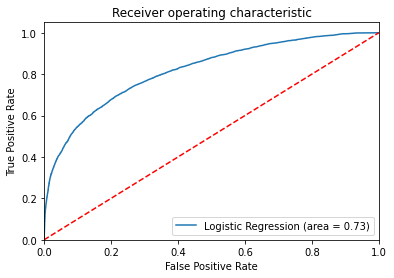

In [ ]:

logit_roc_auc = roc_auc_score(y_testgram, logisticRegr.predict(X_testgram))
fpr, tpr, thresholds = roc_curve(y_testgram, logisticRegr.predict_proba(X_testgram)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
auc_roc_0 = str(roc_auc_score(y_test, predictions))
print('AUC: \n' + auc_roc_0)

AUC: 
0.7316441879455369
